The quantities we need to compute:

* $P(x)$ - raw popularity of each song.  This should be estimated from a training set.

* $P(e ~|~ u)$ - probability of an edge given a user.  Each user has her own distribution over edges when constructing a transition, as estimated by the statistics of $x_s \odot x_t$ for each $(s, t)$ in the user's history.

* $P(x ~|~ e)$ - probability of a song given an edge.  Condition on membership in a particular edge.

  $$
    P(x ~|~ e) = \frac{P(x) \mathbb{1}[x \in e]}{\sum_{x' \in e} P(x')}
  $$
  
* $P(x ~|~ u, x_p)$ - probability of a song selection given the user and previous song $x_p$.  This can be decomposed in terms of the above as

$$
P(x ~|~ u, x_p) = \sum_e P(x, e ~|~ u, x_p) = \sum_{e} P(x ~|~ e, u) P(e ~|~ u, x_p) = \sum_e P(x ~|~ e) P(e ~|~ u, x_p)
$$

$$
P(e ~|~ u, x_p) = \frac{P(e ~|~ u) \mathbb{1}[x_p \in e]}{\sum_f P(f ~|~ u) \mathbb{1}[x_p \in f]}
$$

The questions we want to answer:

* Aesthetic diversity: for each user, what is $H(P(e~|~u, e \neq \text{uniform}))$?  
* Breadth vs depth: what is $H(P(e~|~u))$ vs $\mathbf{E}_{x\in u}[P(x~|~u)]$?

## Technicality details

The song $x$ is used to estimate $P(e|u)$, so we need to be careful about how we explain and interpret this quantity.  One way to think of it is: if we were to redraw a song $x$ given our crude knowledge about the user (edge affinity), how likely are we to get *this* song?  In other words, can a model of the user's general style (edges) and knowledge of the gross statistics of track selection (popularity) accurately inform the selection of the track?

  - If so, then the user is 'broad' in the sense that their preferences appear similar to the crowd
  - If not, then the user is 'deep', in that they're selecting unpopular tracks relative to others

## Should we be bayesian?

Probably we will need priors on the distributions $P(x)$ and $P(e | u)$.

* $P(x) \sim \textbf{Dirichlet}(\alpha_0)$  (assume the distribution over all songs is multinomial)
* $P(e ~|~ u) \sim \textbf{Dirichlet}(\alpha_1)$

To be fully bayesian, we should integrate out the posteriors in all relevant computations, rather than taking point estimates (modes).

In [1]:
import pandas as pd
import scipy
import numpy as np

import progressbar
import seaborn
import matplotlib.pyplot as plt
seaborn.set()
%matplotlib inline

In [2]:
def load_edges(*files, **kwargs):
    
    min_size = kwargs.get('min_size', 100)
    
    frames = [pd.read_pickle(_) for _ in files]
    frames = [frame.drop(frame.columns[frame.count() < min_size], axis=1).to_dense()
              for frame in frames]
    
    H = frames.pop(0)
    
    while len(frames):
        H = H.join(frames.pop(0), how='outer', sort=True)
    
    H.index.name = 'song_id'
    H = H.to_sparse()
    return H

In [3]:
def p_edge_given_user(Ht, playlists, alpha=1.0, min_bigrams=5, max_users=None, count_unigrams=False):
    '''Estimate the edge distribution for each user.
    
    Parameters
    ----------
    Ht :  n_edges * n_songs dataframe
    
    playlists : hierarchical dataframe
    
    alpha : scalar or ndarray
        Vector of hyperparameters
        
    '''
    
    
    stats_frame = pd.DataFrame(columns=Ht.index, dtype='float32')
    
    if max_users is None:
        max_users = len(playlists.index.levels[0])
    
    widgets = [progressbar.Percentage(),
               ' ',
               progressbar.Bar(marker=progressbar.RotatingMarker()),
               ' ',
               progressbar.ETA()]
    
    pbar = progressbar.ProgressBar(widgets=widgets, maxval=max_users).start()
    
    for user in playlists.index.levels[0]:
        
        if len(stats_frame) >= max_users:
            break
        
        u_stat = alpha
        n_bigrams = 0
        
        for (mix_id, segment_id), group in playlists.loc[user].groupby(level=[0,1]):
            if count_unigrams:
                u_stat = u_stat + Ht[group['song_id'][0]].to_dense()
                
            for s, t in zip(group['song_id'][:-1], group['song_id'][1:]):
                # Accumulate
                transition = Ht[s] * Ht[t]
                u_stat = u_stat + transition.to_dense()
                n_bigrams += 1
                          
        if n_bigrams < min_bigrams:
            continue
        
        model = scipy.stats.dirichlet(u_stat)
        stats_frame.loc[user] = model.mean()
        
        pbar.update(len(stats_frame.index))
    
    pbar.finish()
    
    return stats_frame

In [4]:
def song_given_edge(song_prob, H_T):
    
    mpe = H_T.dot(song_prob)
    
    return (H_T.divide(mpe['Probability'], axis='index') * song_prob['Probability'])    

In [5]:
def p_song_given_user(playlists, spe_t, edge_given_user, aggregate=scipy.stats.gmean):
    
    song_stats = pd.DataFrame(index=edge_given_user.index, columns=['log probability'])
        
    widgets = [progressbar.Percentage(),
               ' ',
               progressbar.Bar(marker=progressbar.RotatingMarker()),
               ' ',
               progressbar.ETA()]
    
    pbar = progressbar.ProgressBar(widgets=widgets, maxval=len(song_stats.index)).start()
    
    for i, u in enumerate(edge_given_user.index):
        # Get the songs for this user
        user_songs = playlists.loc[u]['song_id']
        u_vec = edge_given_user.loc[u]
        
        song_given_user = u_vec.dot(spe_t[user_songs]).to_frame()
        
        song_stats.loc[u] = song_given_user.apply(aggregate)[0]
        pbar.update(i)
        
    pbar.finish()
    
    return song_stats.applymap(np.log)
        

In [6]:
def h_song_given_user(spe_t, edge_given_user):
    
    song_stats = pd.DataFrame(index=edge_given_user.index, columns=['song entropy'])
        
    widgets = [progressbar.Percentage(),
               ' ',
               progressbar.Bar(marker=progressbar.RotatingMarker()),
               ' ',
               progressbar.ETA()]
    
    pbar = progressbar.ProgressBar(widgets=widgets, maxval=len(song_stats.index)).start()
    
    for i, u in enumerate(edge_given_user.index):
        # Get the songs for this user
        u_vec = edge_given_user.loc[u]
        
        song_stats.loc[u] = scipy.stats.entropy(u_vec.dot(spe_t).values)
        
        pbar.update(i)
        
    pbar.finish()
    
    return song_stats
        

In [7]:
def p_song_given_user_prev(playlists, spe_t, Ht, edge_given_user, aggregate=scipy.stats.gmean):
    
    song_stats = pd.DataFrame(index=edge_given_user.index, columns=['log probability'])
    
    widgets = [progressbar.Percentage(),
               ' ',
               progressbar.Bar(marker=progressbar.RotatingMarker()),
               ' ',
               progressbar.ETA()]
    
    pbar = progressbar.ProgressBar(widgets=widgets, maxval=len(song_stats.index)).start()
    
    for i, u in enumerate(edge_given_user.index):
        # Get the songs for this user
        user_songs = playlists.loc[u]['song_id']
        u_vec = edge_given_user.loc[u]
        
        song_given_user = []
        
        for (mix_id, segment_id), group in playlists.loc[u].groupby(level=[0,1]):
            for s, t in zip(group['song_id'][:-1], group['song_id'][1:]):
                # Accumulate
                u_vec = (Ht[s] * edge_given_user.loc[u]).to_dense()
                song_given_user.append(u_vec.T.dot(spe_t[t].to_dense()) / u_vec.sum())
        
        song_stats.loc[u] = pd.DataFrame(song_given_user).apply(aggregate)[0]
        
        pbar.update(i)
        
    pbar.finish()
    
    return song_stats.applymap(np.log)
        

In [8]:
def song_counts(playlists, songs):
    raw_counts = pd.Series(data=0.0, index=songs) + playlists.groupby('song_id')['timestamp'].aggregate('count')
    raw_counts = raw_counts.fillna(0).to_frame(name='Counts')
    raw_counts.index.name = 'song_id'
    
    return raw_counts

In [9]:
def p_song(playlists, songs, alpha=1.0):
    
    K = len(songs)
    
    raw_counts = song_counts(playlists, songs)
    
    model = scipy.stats.dirichlet(alpha=raw_counts['Counts'] + alpha)
    
    probs = pd.DataFrame(index=raw_counts.index,
                         columns=['Probability'],
                         data=model.mean())
    
    return probs

In [10]:
def get_song_names():
    
    song_names = pd.read_json('/home/bmcfee/git/playlist_recommender/data/valid_songs.json', orient='index')
    song_names.index.name = 'song_id'
    return song_names

In [11]:
def get_user(playlists, user):
    
    return playlists.loc[[user]].join(song_names, on='song_id')

In [12]:
song_names = get_song_names()

In [13]:
fold = 0

In [14]:
playlists_train = pd.read_pickle('/home/bmcfee/git/playlist_recommender/data/folds/{:d}_train.pickle'.format(fold))
playlists_test = pd.read_pickle('/home/bmcfee/git/playlist_recommender/data/folds/{:d}_test.pickle'.format(fold))

In [16]:
H_frame = load_edges('/home/bmcfee/git/playlist_recommender/data/edges/uniform.pickle',
                     '/home/bmcfee/git/playlist_recommender/data/edges/tags.pickle',
                     '/home/bmcfee/git/playlist_recommender/data/edges/era_decade.pickle',
                     '/home/bmcfee/git/playlist_recommender/data/edges/era_year.pickle',
                     '/home/bmcfee/git/playlist_recommender/data/edges/audio.pickle',
                     min_size=200)

In [17]:
H_frame = H_frame.to_sparse(fill_value=0.0)

In [57]:
H_frame_T = pd.DataFrame(index=H_frame.columns,
                         columns=H_frame.index,
                         data=H_frame.values.T)

In [ ]:
#H_frame_T = H_frame.T.to_sparse(fill_value=0.0)

In [ ]:
#raw_counts = song_counts(playlists, H_frame.index)

In [59]:
song_prob = p_song(playlists_train, H_frame.index)

In [60]:
spe_t = song_given_edge(song_prob, H_frame_T)

In [61]:
song_prob.describe()

,Probability
count,114464.000000
mean,0.000009
std,0.000022
min,0.000001
25%,0.000003
50%,0.000003
75%,0.000007
max,0.000934


In [62]:
song_names.loc[song_prob['Probability'].argmax()]

artist                  Pixies
title        Where Is My Mind?
track_id    TRNNGMK128F423F034
Name: SOBBKGF12A8C1311EE, dtype: object

In [63]:
p_egu = p_edge_given_user(H_frame_T, playlists_test, count_unigrams=True, min_bigrams=10)

100% |||||||||||||||||||||||||||||||||||||||||||||||||||||||||||| Time: 0:05:54


In [64]:
edge_diversity = p_egu.drop('[UNIFORM]', axis=1).apply(scipy.stats.entropy, axis=1).to_frame(name='Entropy')

In [65]:
track_diversity = h_song_given_user(spe_t, p_egu)

In [66]:
track_diversity.head(3)

,song entropy
'drew,10.12277
*Meredith*,10.00119
*joshua*,10.12435


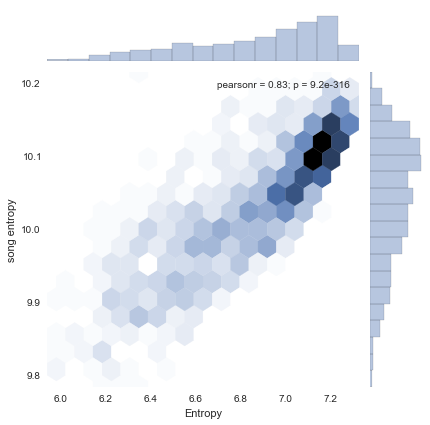

In [67]:
seaborn.jointplot(edge_diversity['Entropy'],
                  track_diversity['song entropy'],
                  kind='hex')

In [68]:
P = p_song_given_user(playlists_test, spe_t, p_egu)

100% |||||||||||||||||||||||||||||||||||||||||||||||||||||||||||| Time: 0:00:09


In [69]:
P2 = p_song_given_user_prev(playlists_test, spe_t, H_frame_T, p_egu)

100% |||||||||||||||||||||||||||||||||||||||||||||||||||||||||||| Time: 0:02:00


Using localized song selection probability


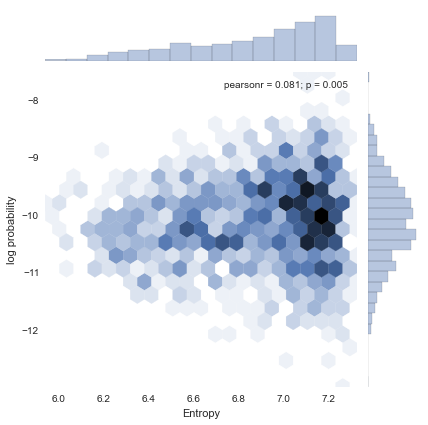

In [70]:
print 'Using localized song selection probability'
seaborn.jointplot(edge_diversity['Entropy'],
                  P2.loc[p_egu.index]['log probability'],
                  kind='hex')
pass

In [71]:
np.exp(10.2), np.exp(9.8)

(26903.18607429754, 18033.744927828524)

H(Song | user) vs log P(Song = x_t | user)


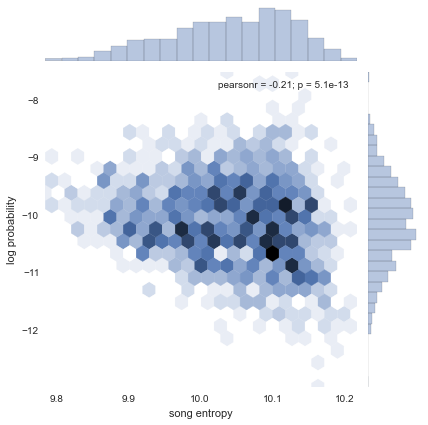

In [72]:
print 'H(Song | user) vs log P(Song = x_t | user)'
seaborn.jointplot(track_diversity['song entropy'], 
                  P2.loc[p_egu.index]['log probability'],
                  kind='hex')
pass

Using global song selection probability


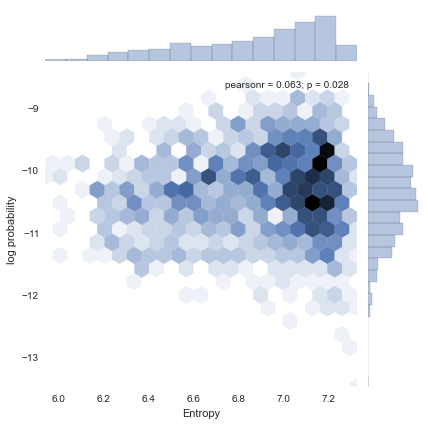

In [73]:
print 'Using global song selection probability'
seaborn.jointplot(edge_diversity['Entropy'],
                  P.loc[p_egu.index]['log probability'],
                  kind='hex')
pass

---
## User investigation

In [74]:
user_descriptions = P2.join(edge_diversity)
user_descriptions.describe()

,log probability,Entropy
count,1213.000000,1213.000000
mean,-10.101792,6.867745
std,0.756290,0.312070
min,-12.977591,5.939288
25%,-10.578391,6.636807
50%,-10.098446,6.952494
75%,-9.597240,7.130816
max,-7.493173,7.325004


In [76]:
import cPickle as pickle

In [81]:
with open('../../data/playlist_analysis_data.pickle', mode='w') as fdesc:
    pickle.dump(dict(p_egu=p_egu,
                     user_descriptions=user_descriptions,
                     playlists_test=playlists_test),
                fdesc, protocol=-1)

In [104]:
import IPython.display

In [96]:
ux = user_descriptions.Entropy.copy()
ux.sort()

In [109]:
lowest_entropy_users = ux.head(10)
highest_entropy_users = ux.tail(10)[::-1]

In [118]:
median_entropy_users = ux._iloc[len(ux)//2 - 5 : len(ux)//2 + 5]

In [119]:
median_entropy_users

Belle de Jour      6.944820
chad lamasa123     6.947069
Melvira            6.947349
Little Sista MC    6.949496
chewtoyheart       6.952231
Beatlmania         6.952494
Sweet Avenue1      6.953287
erin12345678906    6.954031
Garcia1            6.954997
Sneaky P           6.955110
Name: Entropy, dtype: float64

In [110]:
highest_entropy_users

Andruce                  7.325004
Liz1234567               7.324494
Charles Henry Hammons    7.318109
ashley1234567890         7.307551
henry west               7.307510
GlowKitten               7.301056
ReverendGirl             7.298598
jess1234567              7.298397
Molochmayhem             7.294469
Fence Wilson             7.290846
Name: Entropy, dtype: float64

In [113]:
print 'Broadest users'
for user in highest_entropy_users.index:
    print highest_entropy_users.loc[[user]]
    IPython.display.display(get_user(playlists_test, user))
    print

Broadest users
Andruce    7.325004
Name: Entropy, dtype: float64


category             song_id  \
user    mix_id segment_id segment_position                                    
Andruce 6920   0          0                 Mixed Genre  SODMAYX12A6D4F7AC4   
               1          0                 Mixed Genre  SOSJVCO12A8C136E93   
                          1                 Mixed Genre  SOERSBA12A6D4F9823   
               2          0                 Mixed Genre  SOQWSCJ12A8AE46F1C   
                          1                 Mixed Genre  SOANAXD12A8C131EE5   
                          2                 Mixed Genre  SOWTICW12A6D4FB01C   
                          3                 Mixed Genre  SORKLFE12A8C13714A   
               3          0                 Mixed Genre  SOGWZLB12AB017D019   
                          1                 Mixed Genre  SOIJNRR12A8C1398DA   
               4          0                 Mixed Genre  SOIIJMZ12AB018D1C2   
                          1                 Mixed Genre  SOPARAM12A6D4F80AD   
                          2                 Mixed Genre  SOBBSGU12A6D4FB8E0   
                          3                 Mixed Genre  SOFLPNB12A6701CFAE   
                          4                 Mixed Genre  SOLHPPH12A8C135426   
               5          0                 Mixed Genre  SOORSAZ12A8C13F5C5   
                          1                 Mixed Genre  SOXVSTE12AB017C6A8   
                          2                 Mixed Genre  SOXLBRB12AF729DD4F   
               6          0                 Mixed Genre  SOYQGNF12A6310D857   

                                               timestamp  \
user    mix_id segment_id segment_position                 
Andruce 6920   0          0                 970355640000   
               1          0                 970355640000   
                          1                 970355640000   
               2          0                 970355640000   
                          1                 970355640000   
                          2                 970355640000   
                          3                 970355640000   
               3          0                 970355640000   
                          1                 970355640000   
               4          0                 970355640000   
                          1                 970355640000   
                          2                 970355640000   
                          3                 970355640000   
                          4                 970355640000   
               5          0                 970355640000   
                          1                 970355640000   
                          2                 970355640000   
               6          0                 970355640000   

                                                                       artist  \
user    mix_id segment_id segment_position                                      
Andruce 6920   0          0                                      Beastie Boys   
               1          0                                       Nerf Herder   
                          1                                     The Wannadies   
               2          0                                       The Prodigy   
                          1                 Sly & The Family Stone;Devin Lima   
                          2                                            Weezer   
                          3                                   Third Eye Blind   
               3          0                                   Jungle Brothers   
                          1                                       Get Up Kids   
               4          0                                  The Promise Ring   
                          1                                 Edison Lighthouse   
                          2                                        The Queers   
                          3                                         The Roots   
                          4                       


Liz1234567    7.324494
Name: Entropy, dtype: float64


category             song_id  \
user       mix_id segment_id segment_position                                  
Liz1234567 1036   0          0                 Road Trip  SODCJDX12A6310D8E0   
                             1                 Road Trip  SOCZEXG12AB018DBBD   
                             2                 Road Trip  SOROLJV12A8C143FED   
                             3                 Road Trip  SOUQZOX12AF72A6335   
                  1          0                 Road Trip  SOIRTDQ12A6D4F768D   
                             1                 Road Trip  SOLBPNT12A8C13DB30   
                             2                 Road Trip  SOZDIOV12A6701D7E9   
                             3                 Road Trip  SOQJGEQ12A6D4F72D8   
                  2          0                 Road Trip  SOKGBBT12A6701F64C   
                             1                 Road Trip  SOFQUCO12AF72AB128   
                             2                 Road Trip  SOYGMPF12A67ADE5EF   
                             3                 Road Trip  SOIUBTI12A8C13C36D   
                             4                 Road Trip  SOOJLSM12AB0180267   
                             5                 Road Trip  SOFSNFZ12A6701E171   
                             6                 Road Trip  SOXHWFJ12B0B809CBF   

                                                  timestamp  \
user       mix_id segment_id segment_position                 
Liz1234567 1036   0          0                 913766400000   
                             1                 913766400000   
                             2                 913766400000   
                             3                 913766400000   
                  1          0                 913766400000   
                             1                 913766400000   
                             2                 913766400000   
                             3                 913766400000   
                  2          0                 913766400000   
                             1                 913766400000   
                             2                 913766400000   
                             3                 913766400000   
                             4                 913766400000   
                             5                 913766400000   
                             6                 913766400000   

                                                              artist  \
user       mix_id segment_id segment_position                          
Liz1234567 1036   0          0                        Ben Folds Five   
                             1                             Tuscadero   
                             2                       Porno For Pyros   
                             3                            Eurythmics   
                  1          0                             Liz Phair   
                             1                            Chaka Khan   
                             2                       The Temptations   
                             3                          The Breeders   
                  2          0                 The Mamas & The Papas   
                             1                               Warrant   
                             2                            The Smiths   
                             3                        Throwing Muses   
                             4                      Jane's Addiction   
                             5                            Pretenders   
                             6                               Cracker   

                                                                       title  \
user       mix_id segment_id segment_position                                  
Liz1234567 1036   0          0                               Jackson Cannery   
                             1                     Freak Magnet (LP Version)   
                             2                          Meija ( LP Ver


Charles Henry Hammons    7.318109
Name: Entropy, dtype: float64


category  \
user                  mix_id segment_id segment_position                  
Charles Henry Hammons 12661  0          0                 Single Artist   
                                        1                 Single Artist   
                                        2                 Single Artist   
                                        3                 Single Artist   
                                        4                 Single Artist   
                                        5                 Single Artist   
                                        6                 Single Artist   
                                        7                 Single Artist   
                                        8                 Single Artist   
                                        9                 Single Artist   
                                        10                Single Artist   

                                                                     song_id  \
user                  mix_id segment_id segment_position                       
Charles Henry Hammons 12661  0          0                 SONXGNZ12B0B809072   
                                        1                 SOCWTWB12A58A7E4A4   
                                        2                 SORVWZW12B0B809065   
                                        3                 SOBRFBV12A8C142C8B   
                                        4                 SOVOHSX12AF72A1784   
                                        5                 SOEGBGW12A8C142CA0   
                                        6                 SOZKJDM12A8C143448   
                                        7                 SONYCSG12A8C143420   
                                        8                 SOUWEOU12A8C14345C   
                                        9                 SOIZSCO12A8C143498   
                                        10                SOMIEDP12A6D4FD1C8   

                                                             timestamp artist  \
user                  mix_id segment_id segment_position                        
Charles Henry Hammons 12661  0          0                 992655960000   Ween   
                                        1                 992655960000   Ween   
                                        2                 992655960000   Ween   
                                        3                 992655960000   Ween   
                                        4                 992655960000   Ween   
                                        5                 992655960000   Ween   
                                        6                 992655960000   Ween   
                                        7                 992655960000   Ween   
                                        8                 992655960000   Ween   
                                        9                 992655960000   Ween   
                                        10                992655960000   Ween   

                                                                                      title  \
user                  mix_id segment_id segment_position                                      
Charles Henry Hammons 12661  0          0                        Back To Basom (LP Version)   
                                        1                     Bananas And Blow (LP Version)   
                                        2                    Even If You Don't (LP Version)   
                                        3                 Exactly Where I'm At (LP Version)   
                                        4                          Falling Out (LP Version)   
                                        5                        Flutes Of Chi (LP Version)   
                                        6                            The Grobe (LP Version)   
                                        7                          Ice Castles (LP Version)   
                                        8 


ashley1234567890    7.307551
Name: Entropy, dtype: float64


category  \
user             mix_id segment_id segment_position                
ashley1234567890 12754  0          0                 Mixed Genre   
                                   1                 Mixed Genre   
                        2          0                 Mixed Genre   
                                   1                 Mixed Genre   
                                   2                 Mixed Genre   
                        3          0                 Mixed Genre   
                                   1                 Mixed Genre   
                                   2                 Mixed Genre   
                                   3                 Mixed Genre   
                                   4                 Mixed Genre   
                        4          0                 Mixed Genre   
                                   1                 Mixed Genre   
                                   2                 Mixed Genre   
                        5          0                 Mixed Genre   
                                   1                 Mixed Genre   

                                                                song_id  \
user             mix_id segment_id segment_position                       
ashley1234567890 12754  0          0                 SOVCZBU12AB0184C69   
                                   1                 SOJHGZZ12A8AE46FD4   
                        2          0                 SOWWNHU12A8AE467D0   
                                   1                 SOMTDBP12A6D4F8256   
                                   2                 SOGWFYN12A8C14413D   
                        3          0                 SOAKSTJ12AB0187188   
                                   1                 SODKCAI12A8C133A0B   
                                   2                 SOMGSKY12AB0186EDD   
                                   3                 SOIJNUF12B34F1C0B5   
                                   4                 SOESQNH12A58A79AC3   
                        4          0                 SOGLCXA12A8C137B21   
                                   1                 SOGREYE12A67020419   
                                   2                 SOTFJYO12A8C1366C8   
                        5          0                 SODPKYE12AB01803B9   
                                   1                 SOASIDK12A81C207C1   

                                                        timestamp  \
user             mix_id segment_id segment_position                 
ashley1234567890 12754  0          0                 992901300000   
                                   1                 992901300000   
                        2          0                 992901300000   
                                   1                 992901300000   
                                   2                 992901300000   
                        3          0                 992901300000   
                                   1                 992901300000   
                                   2                 992901300000   
                                   3                 992901300000   
                                   4                 992901300000   
                        4          0                 992901300000   
                                   1                 992901300000   
                                   2                 992901300000   
                        5          0                 992901300000   
                                   1                 992901300000   

                                                                       artist  \
user             mix_id segment_id segment_position                             
ashley1234567890 12754  0          0                                 Iggy Pop   
                                   1                           New Bomb Turks   
                        2          0                                Tarnation   
                                   1        


henry west    7.30751
Name: Entropy, dtype: float64


category  \
user       mix_id segment_id segment_position                
henry west 1772   0          0                 Mixed Genre   
                             1                 Mixed Genre   
                             2                 Mixed Genre   
                             3                 Mixed Genre   
                  1          0                 Mixed Genre   
                             1                 Mixed Genre   
                             2                 Mixed Genre   
                             3                 Mixed Genre   
                  2          0                 Mixed Genre   
                             1                 Mixed Genre   
                             2                 Mixed Genre   
                             3                 Mixed Genre   
                             4                 Mixed Genre   
                  3          0                 Mixed Genre   
                             1                 Mixed Genre   
                  4          0                 Mixed Genre   
                             1                 Mixed Genre   
                             2                 Mixed Genre   

                                                          song_id  \
user       mix_id segment_id segment_position                       
henry west 1772   0          0                 SOUHBNB12B0B809347   
                             1                 SOFQLKW12AB0189FD8   
                             2                 SOLNDEY12A67021436   
                             3                 SOQVIPD12A8C14384E   
                  1          0                 SOYHYGV12A8AE479B6   
                             1                 SOSROSV12A6D4F9A72   
                             2                 SOTJDBL12A6D4F75E0   
                             3                 SOJNFQR12A8C13F5E9   
                  2          0                 SOHWZTI12AF72A1947   
                             1                 SOOHDEK12A6D4F828C   
                             2                 SOYCFEN12A6D4F7953   
                             3                 SOGGHRK12A8C13C403   
                             4                 SOYKIOA12A6D4FA549   
                  3          0                 SOZKCCH12A81C20E3B   
                             1                 SOITUAG12AB0180735   
                  4          0                 SOKHSIN12AB0183626   
                             1                 SOELEJG12A8C142FA7   
                             2                 SOGUVCK12A58A7E71D   

                                                  timestamp  \
user       mix_id segment_id segment_position                 
henry west 1772   0          0                 926091600000   
                             1                 926091600000   
                             2                 926091600000   
                             3                 926091600000   
                  1          0                 926091600000   
                             1                 926091600000   
                             2                 926091600000   
                             3                 926091600000   
                  2          0                 926091600000   
                             1                 926091600000   
                             2                 926091600000   
                             3                 926091600000   
                             4                 926091600000   
                  3          0                 926091600000   
                             1                 926091600000   
                  4          0                 926091600000   
                             1                 926091600000   
                             2                 926091600000   

                                                                artist  \
user       mix_id segment_id segment_position                            
henry west 1772   0


GlowKitten    7.301056
Name: Entropy, dtype: float64


category  \
user       mix_id segment_id segment_position                
GlowKitten 9769   0          0                 Mixed Genre   
                             1                 Mixed Genre   
                             2                 Mixed Genre   
                             3                 Mixed Genre   
                  1          0                 Mixed Genre   
                             1                 Mixed Genre   
                  2          0                 Mixed Genre   
                  3          0                 Mixed Genre   
                             1                 Mixed Genre   
                  4          0                 Mixed Genre   
                             1                 Mixed Genre   
                             2                 Mixed Genre   
                             3                 Mixed Genre   
                  5          0                 Mixed Genre   
                  6          0                 Mixed Genre   
                             1                 Mixed Genre   
                             2                 Mixed Genre   

                                                          song_id  \
user       mix_id segment_id segment_position                       
GlowKitten 9769   0          0                 SONDBJB12A8C13125F   
                             1                 SOVBORF12AC3DF57B6   
                             2                 SOPAGDK12AB018AC80   
                             3                 SOEIIIL12A8AE46A89   
                  1          0                 SOHPXOY12AB017CFD9   
                             1                 SODBICI12AB017E5DB   
                  2          0                 SOSEBAI12A8C132FEC   
                  3          0                 SOBLBDZ12A6D4F7416   
                             1                 SOQCJJQ12AB0186CB2   
                  4          0                 SOGBGRX12A8C132A1B   
                             1                 SODTUIZ12A6D4FC358   
                             2                 SORNNFD12A8C1442F1   
                             3                 SOLOFYI12A8C145F8D   
                  5          0                 SOAPQRV12AC468AA3E   
                  6          0                 SOJDTYX12A8C13B4D4   
                             1                 SOUDIAF12873FD5545   
                             2                 SOZKJLI12AB018270F   

                                                  timestamp  \
user       mix_id segment_id segment_position                 
GlowKitten 9769   0          0                 982893000000   
                             1                 982893000000   
                             2                 982893000000   
                             3                 982893000000   
                  1          0                 982893000000   
                             1                 982893000000   
                  2          0                 982893000000   
                  3          0                 982893000000   
                             1                 982893000000   
                  4          0                 982893000000   
                             1                 982893000000   
                             2                 982893000000   
                             3                 982893000000   
                  5          0                 982893000000   
                  6          0                 982893000000   
                             1                 982893000000   
                             2                 982893000000   

                                                                 artist  \
user       mix_id segment_id segment_position                             
GlowKitten 9769   0          0                              Fiona Apple   
                             1                         A Perfect Circle   
                             2                          Sarah


ReverendGirl    7.298598
Name: Entropy, dtype: float64


category  \
user         mix_id segment_id segment_position                  
ReverendGirl 4017   0          0                 Single Artist   
                               1                 Single Artist   
                               2                 Single Artist   
                    1          0                 Single Artist   
                    2          0                 Single Artist   
                               1                 Single Artist   
                               2                 Single Artist   
                    3          0                 Single Artist   
                    4          0                 Single Artist   
                               1                 Single Artist   
                               2                 Single Artist   
                               3                 Single Artist   
                               4                 Single Artist   
                               5                 Single Artist   
                               6                 Single Artist   
                    5          0                 Single Artist   
                               1                 Single Artist   
                               2                 Single Artist   
                               3                 Single Artist   

                                                            song_id  \
user         mix_id segment_id segment_position                       
ReverendGirl 4017   0          0                 SOYOMYH12A8BEEEEBE   
                               1                 SODCNVB12A8C138EEC   
                               2                 SODYGTC12AF72A1CFF   
                    1          0                 SOHJWJX12A8BEEEEDA   
                    2          0                 SOJCVEB12A8BEEEEF0   
                               1                 SOFGKBZ12AB0180748   
                               2                 SOGWWNJ12AB017EC98   
                    3          0                 SOIIRHU12AF72A4D7C   
                    4          0                 SODJYUS12A8C13B8A4   
                               1                 SOWXEOC12A8BEEEF0D   
                               2                 SOPCQQL12A8BEEEEFE   
                               3                 SONBYCU12A8C138F07   
                               4                 SOIPOOC12A8BEEEF0B   
                               5                 SOORQHS12A8BEEEEFA   
                               6                 SOOZVBF12A8BEEEF20   
                    5          0                 SOHGFDO12AF72A41CB   
                               1                 SOCNIII12A8BEEEF04   
                               2                 SOURYPC12A8BEEEEEF   
                               3                 SOFPMLY12AF72A413F   

                                                    timestamp          artist  \
user         mix_id segment_id segment_position                                 
ReverendGirl 4017   0          0                 953857140000  The Verve Pipe   
                               1                 953857140000  The Verve Pipe   
                               2                 953857140000  The Verve Pipe   
                    1          0                 953857140000  The Verve Pipe   
                    2          0                 953857140000  The Verve Pipe   
                               1                 953857140000  The Verve Pipe   
                               2                 953857140000  The Verve Pipe   
                    3          0                 953857140000  The Verve Pipe   
                    4          0                 953857140000  The Verve Pipe   
                               1                 953857140000  The Verve Pipe   
                               2                 953857140000  The Verve Pipe   
                               3                 953857140000  The Verve Pipe   
                               4         


jess1234567    7.298397
Name: Entropy, dtype: float64


category             song_id  \
user        mix_id segment_id segment_position                                
jess1234567 16797  0          0                   Theme  SOQJACW12A6D4FD05E   
                              1                   Theme  SOASYSL12A6310D898   
                   1          0                   Theme  SOHUPRL12AB018B38E   
                              1                   Theme  SOBGTVR12A6BD55C92   
                              2                   Theme  SOHGYNZ12A8C13E052   
                              3                   Theme  SOHTXAW12A8C142E41   
                              4                   Theme  SOGPYOX12A6D4F7EDB   
                   2          0                   Theme  SOOZNGS12AB0185170   
                              1                   Theme  SOFHYIB12AB017D72E   
                              2                   Theme  SOZAKXU12A6D4F6893   
                   3          0                   Theme  SOLUHVU12A8C13A225   
                              1                   Theme  SOIIEUC12A6D4FA2C6   
                              2                   Theme  SOKIAJA12A8C13597E   
                              3                   Theme  SOZZNWH12A8AE481B7   
            21232  0          0                   Theme  SOQTZYK12A58A7E220   
                   1          0                   Theme  SOXBNSI12A58A7D44B   

                                                    timestamp  \
user        mix_id segment_id segment_position                  
jess1234567 16797  0          0                 1004208120000   
                              1                 1004208120000   
                   1          0                 1004208120000   
                              1                 1004208120000   
                              2                 1004208120000   
                              3                 1004208120000   
                              4                 1004208120000   
                   2          0                 1004208120000   
                              1                 1004208120000   
                              2                 1004208120000   
                   3          0                 1004208120000   
                              1                 1004208120000   
                              2                 1004208120000   
                              3                 1004208120000   
            21232  0          0                 1012596900000   
                   1          0                 1012596900000   

                                                                artist  \
user        mix_id segment_id segment_position                           
jess1234567 16797  0          0                            Subway Sect   
                              1                       The Human League   
                   1          0                              The Slits   
                              1                          The Pop Group   
                              2                           Joy Division   
                              3                             Swell Maps   
                              4                               Magazine   
                   2          0                                Flipper   
                              1                          Family Fodder   
                              2                         Liquid_ Liquid   
                   3          0                       Mission Of Burma   
                              1                       Public Image Ltd   
                              2                    Young Marble Giants   
                              3                        Scritti Politti   
            21232  0          0                 The Velvet Underground   
                   1          0                              Brian Eno   

                                                                                            title  \
user        mix_id 


Molochmayhem    7.294469
Name: Entropy, dtype: float64


category             song_id  \
user         mix_id segment_id segment_position                                 
Molochmayhem 16721  0          0                 Rock/Pop  SONZFRQ12AB01822E2   
                    1          0                 Rock/Pop  SOVEWJN12A58A80066   
                               1                 Rock/Pop  SOGPPVA12AB017B1FC   
                               2                 Rock/Pop  SOYKKUJ12AB018D16A   
                               3                 Rock/Pop  SOIAUJJ12A58A7FD28   
                               4                 Rock/Pop  SONEVGB12A8AE4672D   
                               5                 Rock/Pop  SOJTQXQ12A81C20B3E   
                    2          0                 Rock/Pop  SOOGFCP12A6D4F679F   
                    3          0                 Rock/Pop  SODGXLF12AB0187E9D   
                               1                 Rock/Pop  SOVNJZT12A8AE4505E   
                               2                 Rock/Pop  SOIGFML12AB017F3C7   
                               3                 Rock/Pop  SOWJMGE12A6D4F58B7   
                               4                 Rock/Pop  SOSEACQ12AAF3B45B7   
                               5                 Rock/Pop  SOEFNZC12AB017E11E   
                               6                 Rock/Pop  SORILPN12A8C135087   
                               7                 Rock/Pop  SOTEMVZ12A58A7CF45   

                                                     timestamp  \
user         mix_id segment_id segment_position                  
Molochmayhem 16721  0          0                 1003940640000   
                    1          0                 1003940640000   
                               1                 1003940640000   
                               2                 1003940640000   
                               3                 1003940640000   
                               4                 1003940640000   
                               5                 1003940640000   
                    2          0                 1003940640000   
                    3          0                 1003940640000   
                               1                 1003940640000   
                               2                 1003940640000   
                               3                 1003940640000   
                               4                 1003940640000   
                               5                 1003940640000   
                               6                 1003940640000   
                               7                 1003940640000   

                                                          artist  \
user         mix_id segment_id segment_position                    
Molochmayhem 16721  0          0                    Celtic Frost   
                    1          0                    Metal Church   
                               1                     DESTRUCTION   
                               2                   Destroyer 666   
                               3                         Anthrax   
                               4                           DEATH   
                               5                   Mercyful Fate   
                    2          0                     Iron Maiden   
                    3          0                   Black Sabbath   
                               1                        Megadeth   
                               2                         Kreator   
                               3                       Metallica   
                               4                 Nuclear Assault   
                               5                         bathory   
                               6                          Accept   
                               7                         Emperor   

                                                                             title  \
user         mix_id segment_id segment_position                                      
Molo


Fence Wilson    7.290846
Name: Entropy, dtype: float64


category  \
user         mix_id segment_id segment_position                
Fence Wilson 3040   0          0                 Mixed Genre   
                    1          0                 Mixed Genre   
                               1                 Mixed Genre   
                               2                 Mixed Genre   
                    2          0                 Mixed Genre   
                    3          0                 Mixed Genre   
                               1                 Mixed Genre   
                    4          0                 Mixed Genre   
                               1                 Mixed Genre   
                               2                 Mixed Genre   
                               3                 Mixed Genre   
                               4                 Mixed Genre   
                    5          0                 Mixed Genre   
                               1                 Mixed Genre   
                    6          0                 Mixed Genre   
                               1                 Mixed Genre   
                               2                 Mixed Genre   

                                                            song_id  \
user         mix_id segment_id segment_position                       
Fence Wilson 3040   0          0                 SOZOIKA12A8AE46AF2   
                    1          0                 SOJBIHD12AB018CB08   
                               1                 SOSTCFP12A8C13EE12   
                               2                 SOEEIWU12A8C13F7BB   
                    2          0                 SOAIYFP12A8C139152   
                    3          0                 SOOVZJC12A6D4F8434   
                               1                 SODSPBS12A6D4FA22A   
                    4          0                 SOJFZEE12A6701D301   
                               1                 SOBSEUZ12AC9071B60   
                               2                 SOPDERA12A8C130A44   
                               3                 SOSQVWN12A6D4F5FD7   
                               4                 SOSCBTX12A67020A1A   
                    5          0                 SOBVWMH12A6D4F4F00   
                               1                 SOBJZCN12A6D4F80E2   
                    6          0                 SONCGWZ12A81C214D9   
                               1                 SOSBQVA12A8C13E182   
                               2                 SODVFEA12AB018A783   

                                                    timestamp  \
user         mix_id segment_id segment_position                 
Fence Wilson 3040   0          0                 944610540000   
                    1          0                 944610540000   
                               1                 944610540000   
                               2                 944610540000   
                    2          0                 944610540000   
                    3          0                 944610540000   
                               1                 944610540000   
                    4          0                 944610540000   
                               1                 944610540000   
                               2                 944610540000   
                               3                 944610540000   
                               4                 944610540000   
                    5          0                 944610540000   
                               1                 944610540000   
                    6          0                 944610540000   
                               1                 944610540000   
                               2                 944610540000   

                                                               artist  \
user         mix_id segment_id segment_position                         
Fence Wilson 3040   0          0                 They Might Be Giants   
                    1         

In [112]:
print 'Narrowest users'
for user in lowest_entropy_users.index:
    print lowest_entropy_users.loc[[user]]
    IPython.display.display(get_user(playlists_test, user))
    print

Narrowest users
Candra    5.939288
Name: Entropy, dtype: float64


category  \
user   mix_id segment_id segment_position                     
Candra 644    0          0                 Electronic Music   
                         1                 Electronic Music   
                         2                 Electronic Music   
              1          0                 Electronic Music   
                         1                 Electronic Music   
              2          0                 Electronic Music   
              3          0                 Electronic Music   
              4          0                 Electronic Music   
                         1                 Electronic Music   
                         2                 Electronic Music   
                         3                 Electronic Music   
       705    0          0                 Electronic Music   
                         1                 Electronic Music   
              1          0                 Electronic Music   
                         1                 Electronic Music   
                         2                 Electronic Music   
       713    0          0                 Electronic Music   
              1          0                 Electronic Music   
              2          0                 Electronic Music   
                         1                 Electronic Music   
              3          0                 Electronic Music   
       909    0          0                    Single Artist   
                         1                    Single Artist   
       913    0          0                 Electronic Music   
              1          0                 Electronic Music   
              2          0                 Electronic Music   
                         1                 Electronic Music   
              3          0                 Electronic Music   
                         1                 Electronic Music   
              4          0                 Electronic Music   
...                                                     ...   
       124130 3          0                      Mixed Genre   
              4          0                      Mixed Genre   
                         1                      Mixed Genre   
       124372 0          0                      Mixed Genre   
                         1                      Mixed Genre   
                         2                      Mixed Genre   
              1          0                      Mixed Genre   
                         1                      Mixed Genre   
                         2                      Mixed Genre   
              3          0                      Mixed Genre   
                         1                      Mixed Genre   
                         2                      Mixed Genre   
                         3                      Mixed Genre   
              4          0                      Mixed Genre   
       124522 0          0                      Mixed Genre   
                         1                      Mixed Genre   
              1          0                      Mixed Genre   
                         1                      Mixed Genre   
                         2                      Mixed Genre   
              2          0                      Mixed Genre   
       126459 0          0                      Mixed Genre   
                         1                      Mixed Genre   
                         2                      Mixed Genre   
                         3                      Mixed Genre   
              1          0                      Mixed Genre   
              2          0                      Mixed Genre   
                         1                      Mixed Genre   
              3          0                      Mixed Genre   
                         1                      Mixed Genre   
                         2                      Mixed Genre   

                                                      song_id      timestamp  \
u


Jenn1234    5.977021
Name: Entropy, dtype: float64


category  \
user     mix_id segment_id segment_position                  
Jenn1234 9454   0          0                   Mixed Genre   
                2          0                   Mixed Genre   
                           1                   Mixed Genre   
         9491   0          0                   Mixed Genre   
                           1                   Mixed Genre   
                1          0                   Mixed Genre   
                           1                   Mixed Genre   
                           2                   Mixed Genre   
                           3                   Mixed Genre   
                           4                   Mixed Genre   
                2          0                   Mixed Genre   
                3          0                   Mixed Genre   
                4          0                   Mixed Genre   
         10732  0          0                   Mixed Genre   
                1          0                   Mixed Genre   
                           1                   Mixed Genre   
                2          0                   Mixed Genre   
                           1                   Mixed Genre   
                3          0                   Mixed Genre   
                           1                   Mixed Genre   
                           2                   Mixed Genre   
         10733  0          0                   Mixed Genre   
                1          0                   Mixed Genre   
                           1                   Mixed Genre   
                           2                   Mixed Genre   
                           3                   Mixed Genre   
                           4                   Mixed Genre   
                           5                   Mixed Genre   
                           6                   Mixed Genre   
                2          0                   Mixed Genre   
...                                                    ...   
         60870  3          1                   Mixed Genre   
                           2                   Mixed Genre   
         61375  0          0                   Mixed Genre   
                           1                   Mixed Genre   
                1          0                   Mixed Genre   
                2          0                   Mixed Genre   
                           1                   Mixed Genre   
                4          0                   Mixed Genre   
                           1                   Mixed Genre   
                           2                   Mixed Genre   
                5          0                   Mixed Genre   
                           1                   Mixed Genre   
         61877  0          0                 Single Artist   
                           1                 Single Artist   
                           2                 Single Artist   
                           3                 Single Artist   
                1          0                 Single Artist   
                           1                 Single Artist   
                           2                 Single Artist   
                2          0                 Single Artist   
                3          0                 Single Artist   
                           1                 Single Artist   
         63842  0          0                   Mixed Genre   
                           1                   Mixed Genre   
                2          0                   Mixed Genre   
                3          0                   Mixed Genre   
                           1                   Mixed Genre   
                4          0                   Mixed Genre   
                5          0                   Mixed Genre   
                           1                   Mixed Genre   

                                                        song_id  \
user     mix_id segment_id segment_position                       
Jenn1234 


CBlaze    5.989926
Name: Entropy, dtype: float64


category             song_id  \
user   mix_id segment_id segment_position                                      
CBlaze 6983   0          0                     Road Trip  SOCQWCC12A8C13F115   
              1          0                     Road Trip  SONGABP12A8C1442D4   
       7261   0          0                   Mixed Genre  SOLVXBZ12A8AE4670B   
                         1                   Mixed Genre  SOZSSUB12A58A7C965   
              1          0                   Mixed Genre  SODGEXW12A6D4FA952   
              2          0                   Mixed Genre  SOFLMPW12A6701CDA6   
                         1                   Mixed Genre  SOYUBZU12A6310E22D   
              3          0                   Mixed Genre  SODUGYI12AF729AC97   
                         1                   Mixed Genre  SOUGTDN12AB018481C   
                         2                   Mixed Genre  SOIHFAK12A6D4F9F79   
              4          0                   Mixed Genre  SOSVEMQ12A6D4F9766   
                         1                   Mixed Genre  SOKFHMK12A8C1395BB   
                         2                   Mixed Genre  SORNNFD12A8C1442F1   
              5          0                   Mixed Genre  SOQBMYC12AB018478B   
              6          0                   Mixed Genre  SOEPIST12AB017C122   
                         1                   Mixed Genre  SOEOHSD12A6701DB16   
       7263   0          0                 Single Artist  SOCFDCL12A8C141679   
                         1                 Single Artist  SOHBQCG12A8C1442A1   
                         2                 Single Artist  SOBZDFV12AB0182373   
                         3                 Single Artist  SOGHPXK12AC4686116   
                         4                 Single Artist  SOCKFVF12A8C1442A7   
                         5                 Single Artist  SOBYDXK12AB0182382   
                         6                 Single Artist  SOIBPPS12A8C141669   
                         7                 Single Artist  SOESQCY12AB01823BA   
              1          0                 Single Artist  SOMUKCJ12A8C1442CE   
                         1                 Single Artist  SOLFEWX12A8C1442C8   
                         2                 Single Artist  SODZDBP12A8C1442C2   
                         3                 Single Artist  SONGABP12A8C1442D4   
                         4                 Single Artist  SOCZOOS12A8C1442AF   
              2          0                 Single Artist  SOJYVPY12A8C1442FA   
...                                                  ...                 ...   
       118415 1          0                   Mixed Genre  SOCDGWC12A8C13382F   
                         1                   Mixed Genre  SOWIMTQ12AB0186D45   
              2          0                   Mixed Genre  SOCIUUU12AF72A6C22   
              3          0                   Mixed Genre  SOLMAIK12A8C13F7B5   
                         1                   Mixed Genre  SOBGXGT12A6D4F5781   
                         2                   Mixed Genre  SOLJYEI12A8C13F7B3   
              4          0                   Mixed Genre  SOOUAZH12A8C135FB3   
       124666 0          0                      Rock/Pop  SOHTDUI12A8C136662   
              1          0                      Rock/Pop  SOICLPM12A58A7E7E7   
              2          0                      Rock/Pop  SOYKDOS12A8AE4773B   
              3          0                      Rock/Pop  SOEDPQM12A81C23413   
                         1                      Rock/Pop  SONJYJE12A8C142D13   
                         2                      Rock/Pop  SOWVEAF12A81C2242D   
                         3                      Rock/Pop  SOQOBZR12A8C13D08F   
              4          0                      Rock/Pop  SOBXWVD12AB0186123   
                         1                      Rock/Pop  SOMBMND12A8C138723   
              5          0                      Rock/Pop  SOWJVFX12A8C13BB0C   
                         1                      


brodiebanky37    6.004043
Name: Entropy, dtype: float64


category  \
user          mix_id segment_id segment_position                
brodiebanky37 949    0          0                 Mixed Genre   
                     1          0                 Mixed Genre   
                                1                 Mixed Genre   
                                2                 Mixed Genre   
                                3                 Mixed Genre   
                                4                 Mixed Genre   
                     2          0                 Mixed Genre   
                                1                 Mixed Genre   
                                2                 Mixed Genre   
                                3                 Mixed Genre   
                     3          0                 Mixed Genre   
                                1                 Mixed Genre   
                                2                 Mixed Genre   
                     4          0                 Mixed Genre   
              1025   0          0                 Mixed Genre   
                     1          0                 Mixed Genre   
                     2          0                 Mixed Genre   
                                1                 Mixed Genre   
                                2                 Mixed Genre   
                     3          0                 Mixed Genre   
                     4          0                 Mixed Genre   
                                1                 Mixed Genre   
                     5          0                 Mixed Genre   
                                1                 Mixed Genre   
                     6          0                 Mixed Genre   
                                1                 Mixed Genre   
                     7          0                 Mixed Genre   
              1026   0          0                    Hardcore   
                     1          0                    Hardcore   
                                1                    Hardcore   
...                                                       ...   
              61944  6          1                 Mixed Genre   
              61946  0          0                 Mixed Genre   
                     1          0                 Mixed Genre   
                     2          0                 Mixed Genre   
                     4          0                 Mixed Genre   
                     5          0                 Mixed Genre   
                     6          0                 Mixed Genre   
                                1                 Mixed Genre   
                     7          0                 Mixed Genre   
                     8          0                 Mixed Genre   
              70568  0          0                 Mixed Genre   
                                1                 Mixed Genre   
                                2                 Mixed Genre   
                     1          0                 Mixed Genre   
                                1                 Mixed Genre   
                                2                 Mixed Genre   
                                3                 Mixed Genre   
                     2          0                 Mixed Genre   
                     3          0                 Mixed Genre   
                     4          0                 Mixed Genre   
              74482  0          0                 Mixed Genre   
                     1          0                 Mixed Genre   
                     2          0                 Mixed Genre   
                     5          0                 Mixed Genre   
                     6          0                 Mixed Genre   
                                1                 Mixed Genre   
                     7          0                 Mixed Genre   
                                1                 Mixed Genre   
                                2                 Mixed Genre   
                     8 


pandorra0    6.010323
Name: Entropy, dtype: float64


category             song_id  \
user      mix_id segment_id segment_position                                    
pandorra0 11766  0          0                       Theme  SOUUTRI12A8C13CB42   
                 1          0                       Theme  SOJQTDA12AB0181540   
                 2          0                       Theme  SODRHUE12A8C144464   
                 3          0                       Theme  SOMVUKM12AB01876E1   
                 4          0                       Theme  SOCKLMJ12A8C136698   
                 5          0                       Theme  SORGSCK12A6310E81C   
                            1                       Theme  SOLYQKS12A6D4FA42B   
                            2                       Theme  SOQMIVG12A679D7E28   
                            3                       Theme  SOAAFAC12A67ADF7EB   
                            4                       Theme  SOVZHAQ12A81C2177F   
          11767  0          0                       Theme  SOKENTC12AB01831F3   
                 1          0                       Theme  SOYLEJQ12A8C136363   
                 2          0                       Theme  SOKUXDI12A58A7BA08   
                            1                       Theme  SOWDWMU12AB017E323   
                            2                       Theme  SOQEJUC12A6310EE07   
                            3                       Theme  SOCDNRK12A58A7D662   
                 3          0                       Theme  SOSNDUI12A6D4FC42A   
                            1                       Theme  SOIEUSE12A6701F50B   
                            2                       Theme  SOPMTTO12AB0183DB9   
                 4          0                       Theme  SOLTRXI12A6D4F814A   
                            1                       Theme  SOHFAFP12A8C13382B   
                            2                       Theme  SOIBYCQ12AF72A3B64   
                 5          0                       Theme  SOSLCRU12A6701DB0B   
                            1                       Theme  SOUTJQA12A81C216B7   
          11770  0          0                    Romantic  SOPWSYX12A58A7CF48   
                 1          0                    Romantic  SOHXMVP12AB017ECDB   
                            1                    Romantic  SOYGZKG12A8C13FC74   
                 2          0                    Romantic  SOBNLES12A679C8053   
                 4          0                    Romantic  SOHYSGA12A8C13E2FD   
                 6          0                    Romantic  SOFNMJF12AF72A7006   
...                                                   ...                 ...   
          95753  3          0                   Narrative  SONPJIJ12A6701F0B0   
                            1                   Narrative  SOXWHOW12A8C13D3F6   
                            2                   Narrative  SOLABNV12A8C13D698   
                 4          0                   Narrative  SOBBKGF12A8C1311EE   
                 5          0                   Narrative  SOKGBEK12A6701E3BE   
                 6          0                   Narrative  SOXRMIZ12A6D4FA7AF   
                            1                   Narrative  SOKYWSI12A6701E979   
                            2                   Narrative  SOZNYGY12A6701E417   
          95754  2          0                   Narrative  SOEWUHK12AB01867FB   
                 4          0                   Narrative  SOCNJMA12A6D4F85C4   
                 5          0                   Narrative  SOWMVYZ12A6D4F5A39   
                 6          0                   Narrative  SODBPRG12A81C21AE1   
                            1                   Narrative  SOULGIV12A8C13916C   
                            2                   Narrative  SOWBXSN12A8C13A9E9   
                 7          0                   Narrative  SOCULJG12A8AE4714D   
          104869 0          0                 Mixed Genre  SOEQTKU12A6D4F5AD9   
                            1                 Mixed Genre  SOXDURW12AC4686547   


Erin H.    6.012121
Name: Entropy, dtype: float64


category             song_id  \
user    mix_id segment_id segment_position                                      
Erin H. 9066   0          0                         Theme  SOXVMHO12A8C1408F8   
               1          0                         Theme  SOLEVBU12AB0184ECA   
                          1                         Theme  SOQMIVG12A679D7E28   
                          2                         Theme  SOLIZIM12A6D4F81BF   
                          3                         Theme  SOPPWHZ12A6D4FA416   
               2          0                         Theme  SOUUSSG12A58A77832   
                          1                         Theme  SOUKOON12AB01824D6   
                          2                         Theme  SODNQHW12A8AE47F91   
                          3                         Theme  SOBNTMC12A6D4FA422   
                          4                         Theme  SOHXRVD12A8C131266   
               3          0                         Theme  SOGKQYK12AB018081D   
        9252   0          0                   Mixed Genre  SOZXSYC12A8C132B85   
                          1                   Mixed Genre  SOGKJDV12AB017FCF3   
               1          0                   Mixed Genre  SOUBUFT12A6D4F761D   
                          1                   Mixed Genre  SOSBJPA12A6D4F7000   
                          2                   Mixed Genre  SOERVNK12A8AE453CC   
                          3                   Mixed Genre  SOUETWN12A6701EB1B   
               2          0                   Mixed Genre  SOPPWHZ12A6D4FA416   
               3          0                   Mixed Genre  SOWXEXD12B0B80BCED   
               4          0                   Mixed Genre  SOWLUAD12A6701C7F8   
                          1                   Mixed Genre  SOIRIOB12A8AE455E1   
                          2                   Mixed Genre  SOXQKEH12A8C137F45   
                          3                   Mixed Genre  SOYRVSP12A6D4F907A   
                          4                   Mixed Genre  SOPRBOB12A8C1447BB   
                          5                   Mixed Genre  SONIKFU12A6701ED4A   
        9253   0          0                         Theme  SOPQLBY12A6310E992   
                          1                         Theme  SOURUXM12A8C1318C5   
               1          0                         Theme  SOIDZHG12A6D4F7983   
               2          0                         Theme  SOWRUTR12AB01860BE   
                          1                         Theme  SOJQFNU12B34F329EE   
...                                                   ...                 ...   
        32280  2          5                   Mixed Genre  SODQHON12A8C138318   
               3          0                   Mixed Genre  SORFHOZ12A6701E129   
               4          0                   Mixed Genre  SOUXANT12A6D4FB048   
               5          0                   Mixed Genre  SOWHIVG12A58A7BF66   
                          1                   Mixed Genre  SOEEYNQ12A8C132864   
               6          0                   Mixed Genre  SOWGXOP12A6701E93A   
        39037  2          0                   Mixed Genre  SOBDAQH12A8C136C22   
               3          0                   Mixed Genre  SOAIYFP12A8C139152   
               4          0                   Mixed Genre  SOBNLES12A679C8053   
        39038  0          0                 Single Artist  SOQBLNO12A6701F0BB   
               1          0                 Single Artist  SOXHLBY12A6701F0AD   
               2          0                 Single Artist  SODIFAB12A6701F0B3   
               3          0                 Single Artist  SOFQOEW12A6701F09C   
        39040  0          0                   Mixed Genre  SOKWMPC12A6D4FA41B   
               1          0                   Mixed Genre  SOLBRCR12A6D4F8A12   
               2          0                   Mixed Genre  SOUBAPF12A67021D73   
                          1                   Mixed Genre  SOCXOLF12AF729CBB6   


Joe Gillis1    6.024646
Name: Entropy, dtype: float64


category  \
user        mix_id segment_id segment_position                
Joe Gillis1 2513   1          0                 Mixed Genre   
                   2          0                 Mixed Genre   
                              1                 Mixed Genre   
                              2                 Mixed Genre   
            2554   0          0                       Theme   
                   2          0                       Theme   
                   3          0                       Theme   
                   4          0                       Theme   
                              1                       Theme   
                              2                       Theme   
                              3                       Theme   
                              4                       Theme   
                              5                       Theme   
                   5          0                       Theme   
                              1                       Theme   
            2566   0          0                       Theme   
                              1                       Theme   
                              2                       Theme   
                              3                       Theme   
                   2          0                       Theme   
                              1                       Theme   
                              2                       Theme   
                              3                       Theme   
                              4                       Theme   
                   3          0                       Theme   
                   4          0                       Theme   
                              1                       Theme   
                   6          0                       Theme   
                   7          0                       Theme   
            2567   0          0                       Theme   
...                                                     ...   
            122541 1          1                 Mixed Genre   
                              2                 Mixed Genre   
                              3                 Mixed Genre   
                   2          0                 Mixed Genre   
                   3          0                 Mixed Genre   
                   4          0                 Mixed Genre   
            122543 0          0                 Mixed Genre   
                   1          0                 Mixed Genre   
                   2          0                 Mixed Genre   
                              1                 Mixed Genre   
                              2                 Mixed Genre   
                   3          0                 Mixed Genre   
                   4          0                 Mixed Genre   
                              1                 Mixed Genre   
                              2                 Mixed Genre   
                              3                 Mixed Genre   
                   5          0                 Mixed Genre   
                              1                 Mixed Genre   
            122628 0          0                 Mixed Genre   
                              1                 Mixed Genre   
                   1          0                 Mixed Genre   
                              1                 Mixed Genre   
                   2          0                 Mixed Genre   
                   3          0                 Mixed Genre   
                              1                 Mixed Genre   
                              2                 Mixed Genre   
                   4          0                 Mixed Genre   
                              1                 Mixed Genre   
                              2                 Mixed Genre   
                              3                 Mixed Genre   

                                                           song_id  \
user       


Jarrett1    6.03231
Name: Entropy, dtype: float64


category             song_id  \
user     mix_id segment_id segment_position                                   
Jarrett1 5476   0          0                 Indie Rock  SORDDGI12AB017EEF0   
                           1                 Indie Rock  SOPWBHC12AF72A7B35   
                1          0                 Indie Rock  SOEXHUD12A6D4F72D5   
                2          0                 Indie Rock  SOWRLJR12AB01829E4   
                           1                 Indie Rock  SOJSZFY12AB018D1A0   
                           2                 Indie Rock  SOSYDQC12A8C13A68F   
                3          0                 Indie Rock  SOOQVER12A8C13202D   
                4          0                 Indie Rock  SOBVWRF12A6D4F6184   
                           1                 Indie Rock  SOYCWGF12A58A763E8   
                           2                 Indie Rock  SOLYJVL12A58A7D953   
         5513   0          0                 Indie Rock  SORAVNX12A6310F258   
                1          0                 Indie Rock  SODYWBD12A8C139845   
                4          0                 Indie Rock  SOLYJVL12A58A7D953   
                           1                 Indie Rock  SOJPFKE12A6310EF0D   
                           2                 Indie Rock  SOOZVMW12AF72A86DD   
                           3                 Indie Rock  SOZSSXJ12A6D4F8003   
                           4                 Indie Rock  SOKWSAD12A6310EA6A   
                5          0                 Indie Rock  SOEMNRK12A6D4FCA8E   
                6          0                 Indie Rock  SODWWES12AB0181987   
                           1                 Indie Rock  SOYINFW12A679D8AE6   
                           2                 Indie Rock  SOFLDKP12A6310D7A9   
         5569   0          0                 Indie Rock  SOFAIRS12A6D4FA033   
                           1                 Indie Rock  SOJPFKE12A6310EF0D   
                2          0                 Indie Rock  SORUWMN12A6310F95F   
                           1                 Indie Rock  SOIPKYB12A6D4F566C   
                3          0                 Indie Rock  SOHUIPP12AB017F623   
                4          0                 Indie Rock  SOSZTPW12A8C13C113   
                5          0                 Indie Rock  SOGOISE12A6D4FCA75   
                           1                 Indie Rock  SOIJNRR12A8C1398DA   
                           2                 Indie Rock  SOGAKVC12A8C13329C   
...                                                 ...                 ...   
         22432  1          1                 Indie Rock  SOUOWCQ12A6D4F7658   
                2          0                 Indie Rock  SOGDBSU12A6D4F85B0   
                           1                 Indie Rock  SODLENQ12AF72A3DA9   
                3          0                 Indie Rock  SOINSZQ12A6310F244   
                           1                 Indie Rock  SOPTYAU12A58A80362   
                4          0                 Indie Rock  SOZPRHI12A6D4F917B   
                           1                 Indie Rock  SOKBGHT12A6310DF55   
                5          0                 Indie Rock  SOUNXOC12A6D4FB438   
                           1                 Indie Rock  SOTWSXC12A58A7AC33   
         23400  0          0                 Indie Rock  SOEMNRK12A6D4FCA8E   
                1          0                 Indie Rock  SOYOHAO12A670214EC   
                2          0                 Indie Rock  SONFBPV12A8C13D4AD   
                3          0                 Indie Rock  SOJQXTS12A58A7D064   
                           1                 Indie Rock  SONTZLS12A6D4F7D66   
                           2                 Indie Rock  SOSZOGX12A6D4F85AC   
                           3                 Indie Rock  SOVISQY12AB017DC29   
                           4                 Indie Rock  SOYZJML12A8AE473B1   
                4          0                 Indie Rock  SOBITAC12AB0187103   
         23401  0 


TheKeenGuy (Patrick C. Taylor)    6.059356
Name: Entropy, dtype: float64


category  \
user                           mix_id segment_id segment_position               
TheKeenGuy (Patrick C. Taylor) 1738   0          0                   Rock/Pop   
                                      1          0                   Rock/Pop   
                                                 1                   Rock/Pop   
                                                 2                   Rock/Pop   
                                                 3                   Rock/Pop   
                                                 4                   Rock/Pop   
                                                 5                   Rock/Pop   
                                                 6                   Rock/Pop   
                                                 7                   Rock/Pop   
                                                 8                   Rock/Pop   
                                                 9                   Rock/Pop   
                                      2          0                   Rock/Pop   
                                                 1                   Rock/Pop   
                                                 2                   Rock/Pop   
                                                 3                   Rock/Pop   
                                      3          0                   Rock/Pop   
                               1769   0          0                   Rock/Pop   
                                      2          0                   Rock/Pop   
                                                 1                   Rock/Pop   
                                                 2                   Rock/Pop   
                                                 3                   Rock/Pop   
                                                 4                   Rock/Pop   
                                      3          0                   Rock/Pop   
                                      5          0                   Rock/Pop   
                                                 1                   Rock/Pop   
                                      6          0                   Rock/Pop   
                                      7          0                   Rock/Pop   
                               1771   0          0                   Rock/Pop   
                                      1          0                   Rock/Pop   
                                                 1                   Rock/Pop   
...                                                                       ...   
                               94986  5          1                   Rock/Pop   
                                      6          0                   Rock/Pop   
                               96387  0          0                 Indie Rock   
                                      1          0                 Indie Rock   
                                                 1                 Indie Rock   
                                      2          0                 Indie Rock   
                               125006 0          0                 Indie Rock   
                                                 1                 Indie Rock   
                                      1          0                 Indie Rock   
                                                 1                 Indie Rock   
                                      2          0                 Indie Rock   
                               125027 0          0                 Indie Rock   
                                                 1                 Indie Rock   
                                      1          0                 Indie Rock   
                                                 1                 Indie Rock   
                                                 2                 Indie Rock   
                                                 3                 Indie Rock   
                   


noiseboy    6.07437
Name: Entropy, dtype: float64


category             song_id  \
user     mix_id segment_id segment_position                                    
noiseboy 2796   1          0                       Theme  SOACQHA12A8C143257   
                2          0                       Theme  SOAJGWM12AB0185A48   
                           1                       Theme  SOIMCDE12A6D4F8383   
                3          0                       Theme  SOZSYPY12A6310DF1C   
                           1                       Theme  SOEMXKI12AB01824C9   
                           2                       Theme  SOGPYAQ12A8C132293   
                4          0                       Theme  SOADZIH12A6D4F9776   
                5          0                       Theme  SOFBGNM12AF72A315E   
                6          0                       Theme  SOXONZC12A67ADF6DA   
                           1                       Theme  SOAINXH12A6D4F66F4   
         2797   0          0                    Romantic  SOZRHFX12A6701CD8A   
                           1                    Romantic  SOWZSEB12A6D4F3C95   
                           2                    Romantic  SOMSJIN12A8C13E090   
                           3                    Romantic  SOFXTLN12AB0182B66   
                           4                    Romantic  SOHMTAC12A6701F787   
                           5                    Romantic  SOJTNQQ12AF72A246E   
                1          0                    Romantic  SOIOTFC12AF72A59FD   
                2          0                    Romantic  SONGKGU12A6D4F9826   
                3          0                    Romantic  SOHWCHY12A67020FA8   
                4          0                    Romantic  SOJUVXX12AB017CD86   
                           1                    Romantic  SOKVIDV12AB017AFC6   
         2798   0          0                 Mixed Genre  SOFBFRP12A81C22D05   
                           1                 Mixed Genre  SONFOKB12A8C135901   
                1          0                 Mixed Genre  SOFSYAX12A8C138065   
                           1                 Mixed Genre  SOMXWNY12A58A7961C   
                           2                 Mixed Genre  SOORPXN12A58A7771C   
                2          0                 Mixed Genre  SOAENIA12A8C134CDD   
                3          0                 Mixed Genre  SONLJPQ12A6701FDE6   
                           1                 Mixed Genre  SOHKEYV12AF72AC678   
                           2                 Mixed Genre  SOWOEKH12A58A7E811   
...                                                  ...                 ...   
         101750 3          0                 Mixed Genre  SOBWVGX12AB017BD87   
                           1                 Mixed Genre  SONNSYV12A8C146BEC   
                4          0                 Mixed Genre  SOAQJHG12A6D4FB498   
                           1                 Mixed Genre  SORCQRU12AB0181026   
                           2                 Mixed Genre  SOFUKLE12A58A77DBC   
                           3                 Mixed Genre  SOEDDHP12AB0183791   
                           4                 Mixed Genre  SOQJLWB12A6701E7B3   
                           5                 Mixed Genre  SOOUYTP12B0B8094B6   
         101906 0          0                 Mixed Genre  SOXQQRA12A6701CC04   
                           1                 Mixed Genre  SOFJVKK12A6701D96E   
                           2                 Mixed Genre  SOOPXFY12A6701DE4C   
                1          0                 Mixed Genre  SOQCNCF12A6D4F81B1   
                           1                 Mixed Genre  SOFQRQK12AAF3B4F1D   
                           2                 Mixed Genre  SOFUCZQ12A8C13D296   
                           3                 Mixed Genre  SOMRIZS12A6D4F7C41   
                           4                 Mixed Genre  SOOFYFP12A6D4F7902   
                           5                 Mixed Genre  SOTEXKZ12A6D4FA2EF   
                           6                 Mix

In [120]:
print 'Median users'
for user in median_entropy_users.index:
    print median_entropy_users.loc[[user]]
    IPython.display.display(get_user(playlists_test, user))
    print

Median users
Belle de Jour    6.94482
Name: Entropy, dtype: float64


category  \
user          mix_id segment_id segment_position                
Belle de Jour 10428  0          0                    Break Up   
                     1          0                    Break Up   
                                1                    Break Up   
                     2          0                    Break Up   
                     3          0                    Break Up   
                                1                    Break Up   
                     5          0                    Break Up   
                     6          0                    Break Up   
                                1                    Break Up   
                     7          0                    Break Up   
              11390  0          0                   Narrative   
                     1          0                   Narrative   
                     2          0                   Narrative   
                     3          0                   Narrative   
                     4          0                   Narrative   
                                1                   Narrative   
                     5          0                   Narrative   
              12028  0          0                  Depression   
                     1          0                  Depression   
                     2          0                  Depression   
                                1                  Depression   
                                2                  Depression   
                                3                  Depression   
                     3          0                  Depression   
                                1                  Depression   
                                2                  Depression   
                     5          0                  Depression   
                     6          0                  Depression   
                                1                  Depression   
              12214  0          0                 Mixed Genre   
...                                                       ...   
                                2                 Mixed Genre   
                                3                 Mixed Genre   
                                4                 Mixed Genre   
                                5                 Mixed Genre   
                                6                 Mixed Genre   
                     1          0                 Mixed Genre   
                                1                 Mixed Genre   
                     2          0                 Mixed Genre   
                                1                 Mixed Genre   
                                2                 Mixed Genre   
                     3          0                 Mixed Genre   
                                1                 Mixed Genre   
                     5          0                 Mixed Genre   
                     7          0                 Mixed Genre   
              59829  0          0                   Narrative   
                                1                   Narrative   
                     1          0                   Narrative   
                     2          0                   Narrative   
                                1                   Narrative   
                     3          0                   Narrative   
                     4          0                   Narrative   
                                1                   Narrative   
              90893  0          0                    Romantic   
                     1          0                    Romantic   
                     2          0                    Romantic   
                     3          0                    Romantic   
                     4          0                    Romantic   
                                1                    Romantic   
                                2                    Romantic   
                       


chad lamasa123    6.947069
Name: Entropy, dtype: float64


category  \
user           mix_id segment_id segment_position                
chad lamasa123 381    0          0                  Industrial   
                      1          0                  Industrial   
               418    0          0                 Mixed Genre   
                      1          0                 Mixed Genre   
                      2          0                 Mixed Genre   
                      4          0                 Mixed Genre   
                      6          0                 Mixed Genre   
                                 1                 Mixed Genre   
               419    0          0                 Mixed Genre   
                                 1                 Mixed Genre   
                      1          0                 Mixed Genre   
                      2          0                 Mixed Genre   
                                 1                 Mixed Genre   
                      3          0                 Mixed Genre   
                      4          0                 Mixed Genre   
               426    0          0                 Mixed Genre   
                                 1                 Mixed Genre   
                      1          0                 Mixed Genre   
                      2          0                 Mixed Genre   
                      3          0                 Mixed Genre   
                      4          0                 Mixed Genre   
                                 1                 Mixed Genre   
                      5          0                 Mixed Genre   
               488    0          0                       Theme   
               598    0          0                       Theme   
                                 1                       Theme   
                                 2                       Theme   
                      1          0                       Theme   
                                 1                       Theme   
                      2          0                       Theme   
                                 1                       Theme   
                                 2                       Theme   
                      3          0                       Theme   
                      5          0                       Theme   
                      6          0                       Theme   
               599    0          0                       Theme   
                      1          0                       Theme   
                      2          0                       Theme   
                      3          0                       Theme   
                                 1                       Theme   
                      4          0                       Theme   
                      5          0                       Theme   
                                 1                       Theme   
                                 2                       Theme   
                                 3                       Theme   
               720    0          0                 Mixed Genre   
                      1          0                 Mixed Genre   
                      2          0                 Mixed Genre   
                      3          0                 Mixed Genre   
                      4          0                 Mixed Genre   
                      5          0                 Mixed Genre   
                      6          0                 Mixed Genre   
                      7          0                 Mixed Genre   

                                                              song_id  \
user           mix_id segment_id segment_position                       
chad lamasa123 381    0          0                 SOXBVCS12A6701C7FE   
                      1          0                 SOFQCVE12AB01807A8   
               418    0          0                 SOBYPJW12A8C1442B4   
                      1          0                 SOIYEFV


Melvira    6.947349
Name: Entropy, dtype: float64


category             song_id  \
user    mix_id segment_id segment_position                                      
Melvira 1638   0          0                    Depression  SOAPVIO12A6701F509   
                          1                    Depression  SOQAHMM12AB0183334   
               1          0                    Depression  SOVOQAH12A8C133D34   
               2          0                    Depression  SOEKWXM12A6D4F89F6   
               3          0                    Depression  SODNPMR12A67020CEB   
               4          0                    Depression  SOTZQFC12AB01816F2   
        1641   0          0                 Single Artist  SOCKJVP12A6D4F920C   
                          1                 Single Artist  SOSIORU12A58291A54   
                          2                 Single Artist  SOAGGRW12A6D4F920E   
                          3                 Single Artist  SOJSARD12AF729E105   
                          4                 Single Artist  SODSSPQ12A58A7EFCD   
               1          0                 Single Artist  SOBJXHH12A58A7AEB9   
                          1                 Single Artist  SOLDJLX12A6D4F9A78   
               2          0                 Single Artist  SOSBNUV12A58A7DB10   
                          1                 Single Artist  SORJGYU12A81C20961   
                          2                 Single Artist  SOSQQBM12A6D4F91FE   
                          3                 Single Artist  SODHKRI12A6D4F9201   
                          4                 Single Artist  SOHMLDY12AF72A1F78   
                          5                 Single Artist  SOBMBPH12A6D4F9205   
                          6                 Single Artist  SOVNVAP12A6D4F9206   
                          7                 Single Artist  SOXHPFA12AC4688D9D   
                          8                 Single Artist  SOHSRVW12A58A7ED17   
        2649   0          0                    Depression  SOJZDMW12A8151E092   
               2          0                    Depression  SOPFWXB12A8C130ED3   
               3          0                    Depression  SOMZDOS12AF72A56B9   
                          1                    Depression  SOLLTVP12A6310F136   
               4          0                    Depression  SOMDJRE12AF72A7325   
               5          0                    Depression  SOIQDTP12A8C1319DC   
                          1                    Depression  SOBVFZY12AB0187D91   
               6          0                    Depression  SOUQQFU12A67AE1385   
        10212  0          0                         Theme  SOXNMQN12AB01831AA   
                          1                         Theme  SOBXUHH12A8C137D54   
               1          0                         Theme  SOTCLCI12A58A7A94C   
               3          0                         Theme  SOQXION12A8C145031   
                          1                         Theme  SOKVSAP12A8C1359CE   
               4          0                         Theme  SOJAJVT12AB017E891   
                          1                         Theme  SORQWAG12A8C135F55   
                          2                         Theme  SOGIVSP12AF729A146   
               5          0                         Theme  SOCYUJL12A81C22DC4   

                                               timestamp  \
user    mix_id segment_id segment_position                 
Melvira 1638   0          0                 923960160000   
                          1                 923960160000   
               1          0                 923960160000   
               2          0                 923960160000   
               3          0                 923960160000   
               4          0                 923960160000   
        1641   0          0                 923965260000   
                          1                 923965260000   
                          2                 923965260000   
                          3                 923965260000   
       


Little Sista MC    6.949496
Name: Entropy, dtype: float64


category  \
user            mix_id segment_id segment_position                
Little Sista MC 9801   0          0                 Mixed Genre   
                                  1                 Mixed Genre   
                       2          0                 Mixed Genre   
                       3          0                 Mixed Genre   
                       4          0                 Mixed Genre   
                       5          0                 Mixed Genre   
                       6          0                 Mixed Genre   
                                  1                 Mixed Genre   
                9802   0          0                 Mixed Genre   
                                  1                 Mixed Genre   
                                  2                 Mixed Genre   
                       1          0                 Mixed Genre   
                       2          0                 Mixed Genre   
                                  1                 Mixed Genre   
                       3          0                 Mixed Genre   
                                  1                 Mixed Genre   
                       4          0                 Mixed Genre   
                                  1                 Mixed Genre   
                10199  0          0                 Mixed Genre   
                       1          0                 Mixed Genre   
                                  1                 Mixed Genre   
                       2          0                 Mixed Genre   
                       3          0                 Mixed Genre   
                       4          0                 Mixed Genre   
                10995  0          0                 Mixed Genre   
                10996  0          0                 Mixed Genre   
                                  1                 Mixed Genre   
                                  2                 Mixed Genre   
                       1          0                 Mixed Genre   
                       3          0                 Mixed Genre   
...                                                         ...   
                10997  3          0                 Mixed Genre   
                                  1                 Mixed Genre   
                                  2                 Mixed Genre   
                                  3                 Mixed Genre   
                       4          0                 Mixed Genre   
                                  1                 Mixed Genre   
                10998  0          0                 Mixed Genre   
                                  1                 Mixed Genre   
                                  2                 Mixed Genre   
                                  3                 Mixed Genre   
                                  4                 Mixed Genre   
                       1          0                 Mixed Genre   
                       2          0                 Mixed Genre   
                14477  0          0                 Mixed Genre   
                       1          0                 Mixed Genre   
                                  1                 Mixed Genre   
                       2          0                 Mixed Genre   
                                  1                 Mixed Genre   
                                  2                 Mixed Genre   
                       3          0                 Mixed Genre   
                       4          0                 Mixed Genre   
                       5          0                 Mixed Genre   
                16750  0          0                 Mixed Genre   
                       1          0                 Mixed Genre   
                                  1                 Mixed Genre   
                                  2                 Mixed Genre   
                       2          0                 Mixed Genre   
                       3          0


chewtoyheart    6.952231
Name: Entropy, dtype: float64


category  \
user         mix_id segment_id segment_position                
chewtoyheart 7896   0          0                 Mixed Genre   
                    1          0                 Mixed Genre   
                               1                 Mixed Genre   
                    2          0                 Mixed Genre   
                               1                 Mixed Genre   
             7905   0          0                       Theme   
                               1                       Theme   
                    1          0                       Theme   
                               1                       Theme   
                    2          0                       Theme   
                    3          0                       Theme   
                    4          0                       Theme   
                               1                       Theme   
                               2                       Theme   
                               3                       Theme   
                               4                       Theme   
                               5                       Theme   
             7957   0          0                       Theme   
                    1          0                       Theme   
                    2          0                       Theme   
                    3          0                       Theme   
                    4          0                       Theme   
                               1                       Theme   
                               2                       Theme   
             8707   0          0                 Mixed Genre   
                               1                 Mixed Genre   
                    1          0                 Mixed Genre   
                    2          0                 Mixed Genre   
                    3          0                 Mixed Genre   
                               1                 Mixed Genre   
...                                                      ...   
             9522   1          0                    Romantic   
                               1                    Romantic   
                    2          0                    Romantic   
                               1                    Romantic   
                               2                    Romantic   
             9542   0          0                   Road Trip   
                    1          0                   Road Trip   
                    2          0                   Road Trip   
                    3          0                   Road Trip   
             9670   0          0                       Theme   
                    2          0                       Theme   
                               1                       Theme   
                    3          0                       Theme   
                    4          0                       Theme   
             9776   0          0                       Theme   
                    2          0                       Theme   
                               1                       Theme   
                    3          0                       Theme   
                    4          0                       Theme   
                               1                       Theme   
                    5          0                       Theme   
             10586  0          0                    Romantic   
                               1                    Romantic   
                    1          0                    Romantic   
                               1                    Romantic   
                    2          0                    Romantic   
                    3          0                    Romantic   
                    4          0                    Romantic   
                               1                    Romantic   
                               2                    Romantic   

                   


Beatlmania    6.952494
Name: Entropy, dtype: float64


category  \
user       mix_id segment_id segment_position                
Beatlmania 13472  0          0                    Romantic   
                             1                    Romantic   
                  1          0                    Romantic   
                  3          0                    Romantic   
                             1                    Romantic   
                             2                    Romantic   
                  4          0                    Romantic   
                  5          0                    Romantic   
           13880  0          0                       Theme   
                  1          0                       Theme   
                  3          0                       Theme   
                             1                       Theme   
           13881  0          0                    Romantic   
                  2          0                    Romantic   
                             1                    Romantic   
                  4          0                    Romantic   
                  5          0                    Romantic   
                  6          0                    Romantic   
                             1                    Romantic   
                             2                    Romantic   
                             3                    Romantic   
                             4                    Romantic   
           13882  0          0                       Theme   
                             1                       Theme   
                             2                       Theme   
                             3                       Theme   
                  2          0                       Theme   
                  3          0                       Theme   
                             1                       Theme   
                             2                       Theme   
                             3                       Theme   
                  5          0                       Theme   
                             1                       Theme   
                             2                       Theme   
                             3                       Theme   
           13883  0          0                 Mixed Genre   
                  1          0                 Mixed Genre   
                  3          0                 Mixed Genre   
                  6          0                 Mixed Genre   
           13884  0          0                       Theme   
                             1                       Theme   
                  1          0                       Theme   
                             1                       Theme   
                             2                       Theme   
                             3                       Theme   
                             4                       Theme   
                             5                       Theme   
                  2          0                       Theme   
                  3          0                       Theme   
                  4          0                       Theme   
                  5          0                       Theme   

                                                          song_id  \
user       mix_id segment_id segment_position                       
Beatlmania 13472  0          0                 SOTGRJA12B0B808EA9   
                             1                 SOJCRUY12A67ADA4C2   
                  1          0                 SOFKPEI12A58A785FC   
                  3          0                 SOLUXCG12A8C13C6F7   
                             1                 SOKHHQG12AB0184C61   
                             2                 SOXNMQN12AB01831AA   
                  4          0                 SOXEKNU12A8C13E26B   
                  5          0                 SOGXPMY12A6701D45F   
           13880  0          0                 SOTWLJL12A58A7DA90   
    


Sweet Avenue1    6.953287
Name: Entropy, dtype: float64


category  \
user          mix_id segment_id segment_position                
Sweet Avenue1 10409  0          0                 Mixed Genre   
                     1          0                 Mixed Genre   
                     2          0                 Mixed Genre   
                                1                 Mixed Genre   
                     3          0                 Mixed Genre   
                                1                 Mixed Genre   
                                2                 Mixed Genre   
                     4          0                 Mixed Genre   
                                1                 Mixed Genre   
              12648  0          0                  Indie Rock   
                     1          0                  Indie Rock   
                     2          0                  Indie Rock   
                                1                  Indie Rock   
                     3          0                  Indie Rock   
              13574  0          0                 Mixed Genre   
                                1                 Mixed Genre   
                     1          0                 Mixed Genre   
                                1                 Mixed Genre   
                     2          0                 Mixed Genre   
                     4          0                 Mixed Genre   
              16230  0          0                  Indie Rock   
                     1          0                  Indie Rock   
                                1                  Indie Rock   
                     2          0                  Indie Rock   
                     3          0                  Indie Rock   
                     4          0                  Indie Rock   
                                1                  Indie Rock   
                                2                  Indie Rock   
              19640  0          0                  Depression   
                                1                  Depression   
                     1          0                  Depression   
                                1                  Depression   
                                2                  Depression   
                                3                  Depression   
                     2          0                  Depression   
                     3          0                  Depression   
              20216  0          0                 Mixed Genre   
                     1          0                 Mixed Genre   
                                1                 Mixed Genre   
                                2                 Mixed Genre   
                     2          0                 Mixed Genre   
                                1                 Mixed Genre   
                     3          0                 Mixed Genre   
                                1                 Mixed Genre   
                     4          0                 Mixed Genre   
                     5          0                 Mixed Genre   
                     6          0                 Mixed Genre   
                                1                 Mixed Genre   
                                2                 Mixed Genre   
                                3                 Mixed Genre   
                     7          0                 Mixed Genre   

                                                             song_id  \
user          mix_id segment_id segment_position                       
Sweet Avenue1 10409  0          0                 SOLNUNW12B0B806613   
                     1          0                 SOTXDUV12A8C1465D8   
                     2          0                 SORFLDI12A8C139C13   
                                1                 SOAHHXM12A8C13E028   
                     3          0                 SOYPAUU12AB01806B8   
                                1                 SOVUBIA12A8C13CE1F   
                               


erin12345678906    6.954031
Name: Entropy, dtype: float64


category  \
user            mix_id segment_id segment_position                
erin12345678906 9448   0          0                 Mixed Genre   
                       1          0                 Mixed Genre   
                       3          0                 Mixed Genre   
                10805  0          0                 Mixed Genre   
                       1          0                 Mixed Genre   
                       2          0                 Mixed Genre   
                                  1                 Mixed Genre   
                                  2                 Mixed Genre   
                       3          0                 Mixed Genre   
                                  1                 Mixed Genre   
                                  2                 Mixed Genre   
                       4          0                 Mixed Genre   
                                  1                 Mixed Genre   
                                  2                 Mixed Genre   
                                  3                 Mixed Genre   
                       6          0                 Mixed Genre   
                                  1                 Mixed Genre   
                                  2                 Mixed Genre   
                                  3                 Mixed Genre   
                11066  0          0                 Mixed Genre   
                                  1                 Mixed Genre   
                       1          0                 Mixed Genre   
                       2          0                 Mixed Genre   
                       3          0                 Mixed Genre   
                                  1                 Mixed Genre   
                       4          0                 Mixed Genre   
                       6          0                 Mixed Genre   
                70720  0          0                 Mixed Genre   
                                  1                 Mixed Genre   
                       1          0                 Mixed Genre   
...                                                         ...   
                       4          0                 Mixed Genre   
                                  1                 Mixed Genre   
                                  2                 Mixed Genre   
                       5          0                 Mixed Genre   
                                  1                 Mixed Genre   
                                  2                 Mixed Genre   
                                  3                 Mixed Genre   
                       6          0                 Mixed Genre   
                       7          0                 Mixed Genre   
                120162 0          0                 Mixed Genre   
                                  1                 Mixed Genre   
                       1          0                 Mixed Genre   
                                  1                 Mixed Genre   
                                  2                 Mixed Genre   
                       2          0                 Mixed Genre   
                                  1                 Mixed Genre   
                                  2                 Mixed Genre   
                       3          0                 Mixed Genre   
                120656 0          0                   Road Trip   
                                  1                   Road Trip   
                       1          0                   Road Trip   
                                  1                   Road Trip   
                       2          0                   Road Trip   
                       3          0                   Road Trip   
                       4          0                   Road Trip   
                                  1                   Road Trip   
                                  2                   Road Trip   
                                  3


Garcia1    6.954997
Name: Entropy, dtype: float64


category             song_id  \
user    mix_id segment_id segment_position                                      
Garcia1 14157  0          0                     Road Trip  SOPSSIO12A6D4F8CFE   
                          1                     Road Trip  SOUSJZQ12A6D4F69CB   
                          2                     Road Trip  SOGJXYT12AC3DFA647   
               1          0                     Road Trip  SOLZZEU12A6D4F82C3   
               2          0                     Road Trip  SOALNCN12A6310F200   
                          1                     Road Trip  SOFEHLB12A8C130EF7   
                          2                     Road Trip  SOMCHMJ12A58A80DCF   
                          3                     Road Trip  SOXFJRD12A8C13BEB7   
               3          0                     Road Trip  SOVRUZG12A6310F13F   
        14163  0          0                   Mixed Genre  SOWOZJP12AAA15D8B3   
               1          0                   Mixed Genre  SODWGKJ12A6701F4FC   
                          1                   Mixed Genre  SOLQZNE12A58A79B6F   
                          2                   Mixed Genre  SOFASVS12A8C1336B9   
                          3                   Mixed Genre  SOCGWNL12A58A7D28D   
               2          0                   Mixed Genre  SOVLDYJ12AB017EB87   
                          1                   Mixed Genre  SOFWQIU12AB0186063   
                          2                   Mixed Genre  SODKEFK12A8C137DFC   
               3          0                   Mixed Genre  SOAYWFB12A3F1EC41C   
                          1                   Mixed Genre  SOFCHIM12A8C138635   
                          2                   Mixed Genre  SOUNRHI12A6D4F8CA4   
               4          0                   Mixed Genre  SOKODFF12A6D4F72C6   
                          1                   Mixed Genre  SOEYSQI12A58A7C47A   
                          2                   Mixed Genre  SOKAHKQ12A58A7D75D   
                          3                   Mixed Genre  SOENNGJ12A6D4FB8D7   
                          4                   Mixed Genre  SOQMDPN12AF72A25EE   
        14165  0          0                         Theme  SONWSRX12A6D4F5D22   
               2          0                         Theme  SODTUIZ12A6D4FC358   
                          1                         Theme  SOREXHX12A6D4F8943   
                          2                         Theme  SORDJJS12A8C13E056   
                          3                         Theme  SOZJULR12AF729D135   
...                                                   ...                 ...   
               4          0                         Theme  SOAEQOW12AB0186299   
        14167  1          0                 Single Artist  SOIUGLT12A8C1382A4   
                          1                 Single Artist  SOMGYPL12A8C13833B   
               2          0                 Single Artist  SOJJYBL12A6701FA22   
                          1                 Single Artist  SOPGPTD12A6310E032   
               3          0                 Single Artist  SOQBQQI12A6310E02F   
               4          0                 Single Artist  SOVJYXY12AC468A93E   
               5          0                 Single Artist  SODQHSI12A8C138326   
               6          0                 Single Artist  SOKGEIM12AF72AD35F   
        14168  0          0                         Theme  SOWOZJP12AAA15D8B3   
                          1                         Theme  SOSHAJP12AB0184848   
               1          0                         Theme  SOXZSSK12A8C144DC7   
                          1                         Theme  SOESTZQ12A67021556   
               2          0                         Theme  SOSXTLA12AB017DAC6   
               3          0                         Theme  SOGJFLW12A8AE47AE8   
               5          0                         Theme  SOFASVS12A8C1336B9   
                          1                         Theme  SOESQNH12A58A79AC3   


Sneaky P    6.95511
Name: Entropy, dtype: float64


category             song_id  \
user     mix_id segment_id segment_position                                    
Sneaky P 16766  0          0                 Mixed Genre  SOVHRGF12A8C13852F   
                           1                 Mixed Genre  SOVSWVR12AAF3B3A9B   
                1          0                 Mixed Genre  SORIYLS12A8C145021   
                2          0                 Mixed Genre  SOGPGBV12A6701EEE5   
                3          0                 Mixed Genre  SOWXUQB12A58A7B83B   
                           1                 Mixed Genre  SOAFTRR12AF72A8D4D   
                           2                 Mixed Genre  SOORJIR12A6D4FC096   
                           3                 Mixed Genre  SOQAWZR12A8C1353AE   
                4          0                 Mixed Genre  SOVEBVJ12A67ADD500   
                           1                 Mixed Genre  SOIIDJM12AB017AFEB   
                           2                 Mixed Genre  SOZKLHS12AB018018F   
                           3                 Mixed Genre  SOJAIDQ12A6310E015   
                           4                 Mixed Genre  SOUFOBC12AB0185331   
                           5                 Mixed Genre  SOOZDTM12AB0185A17   
                5          0                 Mixed Genre  SONALRM12AB01867D5   
                           1                 Mixed Genre  SOYLYUN12A58A7FC93   
         76023  0          0                       Theme  SOZDBDX12AB017E51C   
                           1                       Theme  SOTWNVF12AB0188451   
                1          0                       Theme  SOBBKGF12A8C1311EE   
                2          0                       Theme  SOZBZFF12A6310F12D   
                3          0                       Theme  SOSLPDH12A8C13DDD9   
                4          0                       Theme  SOHBXLJ12AF72AB920   
                           1                       Theme  SOFAIRS12A6D4FA033   
                5          0                       Theme  SOLZWCT12A8C14139C   
                           1                       Theme  SOMJYCM12A8C13B1FF   
         76178  0          0                       Theme  SOYXTWE12AF72A6844   
                           1                       Theme  SOWEJJI12AF72A42EE   
                1          0                       Theme  SOPTSIB12A6D4F6984   
                2          0                       Theme  SOTSNDR12A8AE47599   
                           1                       Theme  SOWSMOW12A6D4F7C2E   
                3          0                       Theme  SOZRYST12812D07C72   
                4          0                       Theme  SOBCOWD12A6701FD78   
                           1                       Theme  SOYZGHC12AB0183F58   
         76317  0          0                 Mixed Genre  SOQATIZ12AB017CFF5   
                1          0                 Mixed Genre  SOHLMLU127BB0A7A10   
                2          0                 Mixed Genre  SOLMUHR12AB018B2D8   
                           1                 Mixed Genre  SODAOYZ12AF72A04B5   
                4          0                 Mixed Genre  SOSOZKR12AB017FF52   
                5          0                 Mixed Genre  SOWRMTF12AB01859D5   
                           1                 Mixed Genre  SOGUBGT12A8C13EAAF   
                6          0                 Mixed Genre  SOGHPHQ12A6D4FA29D   
                           1                 Mixed Genre  SOZSFWF12A6D4F93D5   
                7          0                 Mixed Genre  SOVEDPW12A8C14214A   
                8          0                 Mixed Genre  SOFENYK12CEB121A06   
                9          0                 Mixed Genre  SOKDCMZ12A58A7804A   
                10         0                 Mixed Genre  SOAEFXV12A6D4F86EB   
                           1                 Mixed Genre  SOARGZA12A6701F603   
                11         0                 Mixed Genre  SOJQZGT12AC4684FE4   
                           1                 Mix

---

In [ ]:
# Find the user with the narrowest edge distribution
joe_dist = p_egu.loc[user_descriptions['Entropy'].argmin()]

# And list the 50 most likely edges
joe_dist.sort(ascending=False)
joe_dist.head(50)

In [ ]:
print 'Deepest user'
get_user(playlists_test, user_descriptions['log probability'].argmin())

In [ ]:
print 'Shallowest user'
get_user(playlists_test, user_descriptions['log probability'].argmax())

In [ ]:
import IPython.display

In [ ]:
def sample_users(descriptions, n_users=3, low_p=False, low_h=False):
    
    if low_p:
        descriptions = descriptions[descriptions['log probability'] <= descriptions['log probability'].median()]
    else:
        descriptions = descriptions[descriptions['log probability'] > descriptions['log probability'].median()]
        
    if low_h:
        descriptions = descriptions[descriptions['Entropy'] <= descriptions['Entropy'].median()]
    else:
        descriptions = descriptions[descriptions['Entropy'] > descriptions['Entropy'].median()]
        
    return np.random.choice(descriptions.index, n_users, replace=False)

In [ ]:
user_descriptions.describe()

In [ ]:
print 'DEEP and NARROW'
for user in sample_users(user_descriptions, low_p=True, low_h=True):
    IPython.display.display(get_user(playlists_test, user))

In [ ]:
print 'DEEP and BROAD'
for user in sample_users(user_descriptions, low_p=True, low_h=False):
    IPython.display.display(get_user(playlists_test, user))

In [ ]:
print 'SHALLOW and NARROW'
for user in sample_users(user_descriptions, low_p=False, low_h=True):
    IPython.display.display(get_user(playlists_test, user))

In [ ]:
print 'SHALLOW and BROAD'
for user in sample_users(user_descriptions, low_p=False, low_h=False):
    IPython.display.display(get_user(playlists_test, user))